In [2]:
    from mitreattack.stix20 import MitreAttackData
    mitre_attack_data = MitreAttackData("enterprise-attack.json")

    # get techniques used by G0019
    group_stix_id = "intrusion-set--2a158b0a-7ef8-43cb-9985-bf34d1e12050"
    techniques_used_by_g0019 = mitre_attack_data.get_techniques_used_by_group(group_stix_id)

    print(f"Techniques used by G0019 ({len(techniques_used_by_g0019)}):")
    for t in techniques_used_by_g0019:
        technique = t["object"]
        print(f"* {technique.name} ({mitre_attack_data.get_attack_id(technique.id)})")
    # just go through techniqus_by_g0019 , parse all techniques used  , then extract all the techniques patterns , id , name , kill chain phases , platforms , and attack id 

Techniques used by G0019 (14):
* Domain Accounts (T1078.002)
* Remote System Discovery (T1018)
* Registry Run Keys / Startup Folder (T1547.001)
* Security Software Discovery (T1518.001)
* Network Service Discovery (T1046)
* Windows Management Instrumentation (T1047)
* Add-ins (T1137.006)
* System Network Configuration Discovery (T1016)
* Match Legitimate Name or Location (T1036.005)
* Spearphishing Attachment (T1566.001)
* Masquerade Task or Service (T1036.004)
* Scheduled Task (T1053.005)
* Malicious File (T1204.002)
* DLL Side-Loading (T1574.002)


In [6]:
import pandas as pd

# Get techniques used by the APT group G0019
group_stix_id = "intrusion-set--2a158b0a-7ef8-43cb-9985-bf34d1e12050"
techniques_used_by_g0019 = mitre_attack_data.get_techniques_used_by_group(group_stix_id)

# Initialize an empty list to hold the extracted data
techniques_data = []

# Iterate over each technique used by the group
for t in techniques_used_by_g0019:
    technique = t["object"]
    
    # Extract the necessary fields for each technique
    technique_data = {
        "id": technique.id,  # The unique ID of the attack pattern
        "name": technique.name,  # The name of the attack pattern
        "description": technique.description,  # The description of the attack pattern
        "kill_chain_phases": [kill_chain_phase.phase_name for kill_chain_phase in technique.kill_chain_phases],  # Kill chain phases
        "platforms": technique.x_mitre_platforms,  # The platforms the technique applies to
        "attack_id": mitre_attack_data.get_attack_id(technique.id)  # The MITRE ATT&CK ID
    }
    
    # Append the extracted data to the list
    techniques_data.append(technique_data)

# Convert the extracted data into a pandas DataFrame
df = pd.DataFrame(techniques_data)

# Display the dataframe to the user for easy inspection

# Optional: Save the DataFrame as a CSV or JSON file for further analysis
df.to_json("techniques_data.json", orient="records", lines=True)
df.to_csv("techniques_data.csv", index=False)

# Confirm that the extraction is complete
print("Data extraction complete.")


Data extraction complete.


In [8]:
df.columns

Index(['id', 'name', 'description', 'kill_chain_phases', 'platforms',
       'attack_id'],
      dtype='object')

C:\Users\anisa\AppData\Local\Temp\ipykernel_7488\3962509072.py:180: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(df_combined.applymap(lambda x: x[0]), cmap='YlGnBu', annot=True, fmt=".2f")


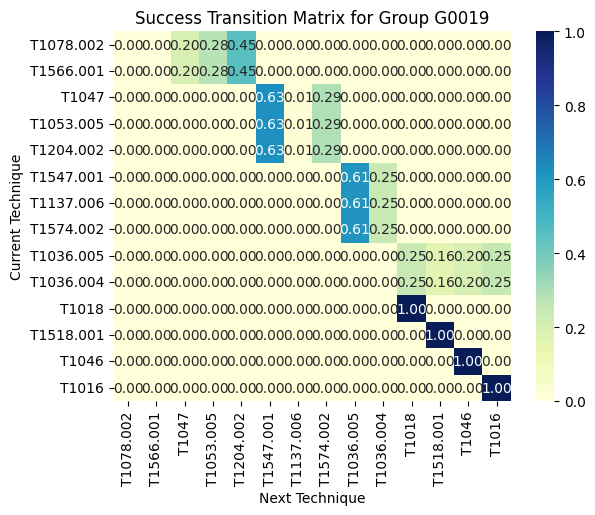

C:\Users\anisa\AppData\Local\Temp\ipykernel_7488\3962509072.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(df_combined.applymap(lambda x: x[1]), cmap='YlGnBu', annot=True, fmt=".2f")


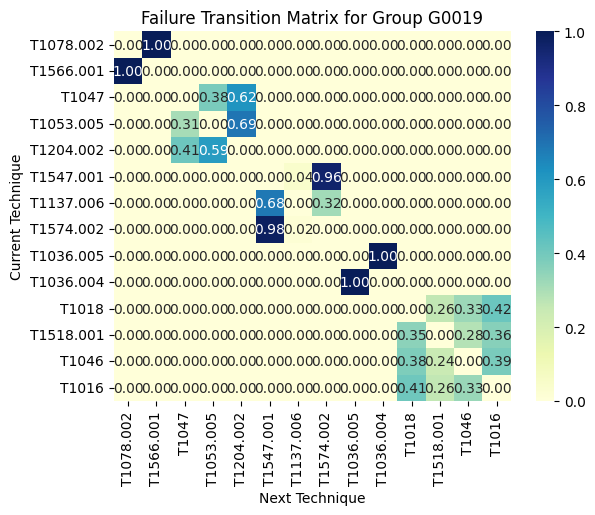

In [9]:
import numpy as np
import pandas as pd
from collections import defaultdict
from mitreattack.stix20 import MitreAttackData
import seaborn as sns
import matplotlib.pyplot as plt

# Load MITRE ATT&CK data
mitre_attack_data = MitreAttackData("enterprise-attack.json")

# Define the canonical tactic order for MITRE ATT&CK Enterprise
canonical_tactic_order = [
    "Reconnaissance",
    "Resource Development",
    "Initial Access",
    "Execution",
    "Persistence",
    "Privilege Escalation",
    "Defense Evasion",
    "Credential Access",
    "Discovery",
    "Lateral Movement",
    "Collection",
    "Command and Control",
    "Exfiltration",
    "Impact"
]

def get_sorted_tactics(technique_id):
    """
    Retrieve and sort the tactics associated with a technique based on the canonical order.
    """
    tactics = mitre_attack_data.get_tactics_by_technique(technique_id)
    sorted_tactics = sorted(
        tactics,
        key=lambda t: canonical_tactic_order.index(t.name)
        if t.name in canonical_tactic_order else len(canonical_tactic_order)
    )
    return sorted_tactics

def get_primary_tactic_index(technique_id):
    """
    Return the index (in the canonical tactic order) of the technique's primary tactic.
    """
    sorted_tactics = get_sorted_tactics(technique_id)
    if sorted_tactics:
        return canonical_tactic_order.index(sorted_tactics[0].name)
    return None  # If no tactic found

# -------------------------------------------
# Retrieve Techniques for a Specific Group
# -------------------------------------------
group_stix_id = "intrusion-set--2a158b0a-7ef8-43cb-9985-bf34d1e12050"  # Example: G0019
techniques_used = mitre_attack_data.get_techniques_used_by_group(group_stix_id)

# Build a list of techniques with their attack ID, primary tactic index, and tactic category.
technique_list = []
for entry in techniques_used:
    tech = entry["object"]
    attack_id = mitre_attack_data.get_attack_id(tech.id)
    primary_index = get_primary_tactic_index(tech.id)
    if primary_index is None:
        continue  # Skip if no tactic available
    tactic_category = canonical_tactic_order[primary_index]
    technique_list.append((tech.id, attack_id, primary_index, tactic_category))

# Sort techniques by their primary tactic index (and then by name if needed)
technique_list.sort(key=lambda x: x[2])
technique_ids    = [x[0] for x in technique_list]
technique_names  = [x[1] for x in technique_list]
tactic_categories = [x[3] for x in technique_list]
n = len(technique_ids)

# -------------------------------------------
# Compute Popularity for Each Technique
# -------------------------------------------
# Get all groups using each technique from MITRE data.
all_groups_usage = mitre_attack_data.get_all_groups_using_all_techniques()

# Create a popularity dictionary: technique_id -> number of groups using it
popularity = {}
for tech_id in technique_ids:
    # If a technique is not found in the usage data, default to 1
    pop = len(all_groups_usage.get(tech_id, []))
    popularity[tech_id] = pop if pop > 0 else 1

# -------------------------------------------
# Build the Failure and Success Transition Matrices
# -------------------------------------------

# Initialize n x n matrices (rows = current technique, columns = next technique)
failure_matrix = np.zeros((n, n))
success_matrix = np.zeros((n, n))

# Group techniques by their tactic category (for easy lookup)
techniques_by_category = defaultdict(list)
for idx, cat in enumerate(tactic_categories):
    techniques_by_category[cat].append(idx)

# 1. Failure Transitions: next technique must be in the SAME tactic category.
for i in range(n):
    current_cat = tactic_categories[i]
    indices_in_cat = techniques_by_category[current_cat]
    # Exclude self-transition if possible
    valid_indices = [j for j in indices_in_cat if j != i]
    if valid_indices:
        # Weight each alternative by its popularity.
        total_weight = sum(popularity[technique_ids[j]] for j in valid_indices)
        for j in valid_indices:
            failure_matrix[i, j] = popularity[technique_ids[j]] / total_weight
    else:
        # If only one technique exists in this tactic category, assign self-transition.
        failure_matrix[i, i] = 1.0

# 2. Success Transitions: next technique must be in the NEXT available tactic category.
for i in range(n):
    current_cat = tactic_categories[i]
    current_cat_index = canonical_tactic_order.index(current_cat)
    # Find the next tactic category (in canonical order) used by the group
    next_category = None
    for cat in canonical_tactic_order[current_cat_index+1:]:
        if cat in techniques_by_category:
            next_category = cat
            break
    if next_category:
        indices_next = techniques_by_category[next_category]
        total_weight = sum(popularity[technique_ids[j]] for j in indices_next)
        for j in indices_next:
            success_matrix[i, j] = popularity[technique_ids[j]] / total_weight
    else:
        # If no higher tactic exists, assign self-transition.
        success_matrix[i, i] = 1.0

# 3. Normalize Transitions: Ensure that each row of success and failure sums to 1.
def normalize_matrix(matrix):
    for i in range(n):
        row_sum = sum(matrix[i, j] for j in range(n))
        if row_sum > 0:
            for j in range(n):
                matrix[i, j] /= row_sum
    return matrix

success_matrix = normalize_matrix(success_matrix)
failure_matrix = normalize_matrix(failure_matrix)

# 4. Incorporate Defense Evasion Factor
defense_evasion_factor = {
    'T1071': 1.2,  # Example: higher chance of success for certain techniques like T1071 (Application Layer Protocol)
}

# Add the defense evasion factor to transitions
for i in range(n):
    for j in range(n):
        if technique_ids[i] in defense_evasion_factor:
            success_matrix[i, j] *= defense_evasion_factor[technique_ids[i]]
            failure_matrix[i, j] *= (1 - defense_evasion_factor.get(technique_ids[i], 1))

# 5. Introduce Temporal Weight (Consider techniques executed in earlier or later phases)
for i in range(n):
    for j in range(n):
        temporal_factor = 1 - (canonical_tactic_order.index(tactic_categories[j]) - canonical_tactic_order.index(tactic_categories[i])) / len(canonical_tactic_order)
        success_matrix[i, j] *= temporal_factor
        failure_matrix[i, j] *= temporal_factor

# -------------------------------------------
# Combine into a Single Matrix of Tuples (success, failure)
# -------------------------------------------
combined_matrix = np.empty((n, n), dtype=object)
for i in range(n):
    for j in range(n):
        # Each cell is a tuple: (success probability, failure probability)
        combined_matrix[i, j] = (success_matrix[i, j], failure_matrix[i, j])

# Convert to DataFrame for visualization
df_combined = pd.DataFrame(combined_matrix, index=technique_names, columns=technique_names)

# -------------------------------------------
# Visualization: Heatmap of Transition Matrix
# -------------------------------------------
sns.heatmap(df_combined.applymap(lambda x: x[0]), cmap='YlGnBu', annot=True, fmt=".2f")
plt.title("Success Transition Matrix for Group G0019")
plt.xlabel("Next Technique")
plt.ylabel("Current Technique")
plt.show()

sns.heatmap(df_combined.applymap(lambda x: x[1]), cmap='YlGnBu', annot=True, fmt=".2f")
plt.title("Failure Transition Matrix for Group G0019")
plt.xlabel("Next Technique")
plt.ylabel("Current Technique")
plt.show()


In [14]:
df_combined

,T1078.002,T1566.001,T1047,T1053.005,T1204.002,T1547.001,T1137.006,T1574.002,T1036.005,T1036.004,T1018,T1518.001,T1046,T1016
T1078.002,"(0.0, 0.0)","(0.0, 1.0)","(0.19780219780219782, 0.0)","(0.2802197802197802, 0.0)","(0.45054945054945056, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
T1566.001,"(0.0, 1.0)","(0.0, 0.0)","(0.19780219780219782, 0.0)","(0.2802197802197802, 0.0)","(0.45054945054945056, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
T1047,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.38345864661654133)","(0.0, 0.6165413533834586)","(0.62708719851577, 0.0)","(0.012059369202226347, 0.0)","(0.2894248608534323, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
T1053.005,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.3050847457627119)","(0.0, 0.0)","(0.0, 0.6949152542372882)","(0.62708719851577, 0.0)","(0.012059369202226347, 0.0)","(0.2894248608534323, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
T1204.002,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.41379310344827586)","(0.0, 0.5862068965517241)","(0.0, 0.0)","(0.62708719851577, 0.0)","(0.012059369202226347, 0.0)","(0.2894248608534323, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
T1547.001,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.04)","(0.0, 0.96)","(0.6107142857142858, 0.0)","(0.24642857142857144, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
T1137.006,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.6842105263157895)","(0.0, 0.0)","(0.0, 0.3157894736842105)","(0.6107142857142858, 0.0)","(0.24642857142857144, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
T1574.002,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.9811320754716981)","(0.0, 0.018867924528301886)","(0.0, 0.0)","(0.6107142857142858, 0.0)","(0.24642857142857144, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
T1036.005,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 1.0)","(0.24685714285714286, 0.0)","(0.15771428571428572, 0.0)","(0.19885714285714287, 0.0)","(0.2537142857142857, 0.0)"
T1036.004,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)","(0.24685714285714286, 0.0)","(0.15771428571428572, 0.0)","(0.19885714285714287, 0.0)","(0.2537142857142857, 0.0)"
